In [1]:
import os
import glob
import random
import torch

from obspy import Stream
from obspy import read
from obspy.signal.trigger import classic_sta_lta

import numpy as np 
import scipy.signal as signal
import matplotlib.pyplot as plt 

In [2]:
def scale_amplitude(data, rate):
    'Scale amplitude or waveforms'
    
    tmp = np.random.uniform(0, 1)
    if tmp < rate:
        data *= np.random.uniform(1, 3)
    elif tmp < 2*rate:
        data /= np.random.uniform(1, 3)
    return data

In [3]:
def shift_event(data, maxshift, rate, start, halfdim): 
    'Randomly rotate the array to shift the event location'
    
    if np.random.uniform(0, 1) < rate:
        start += int(np.random.uniform(-maxshift, maxshift))

    start = max(min(start, len(data[0]) - halfdim), halfdim)
    return data[:, start-halfdim:start + halfdim]

In [4]:
data_per_noise = 1

In [5]:
def get_trigger_sample_0(input_Stream, sta_window = 1, lta_window = 5, threshold = 3.01):

    for i in range(3):
        
        tr = input_Stream[i]

        # Apply STA/LTA trigger
        cft = classic_sta_lta(tr.data, int(sta_window * tr.stats.sampling_rate), int(lta_window * tr.stats.sampling_rate))
        
        trigger_samples_list = np.where(cft > threshold)[0]

        if len(trigger_samples_list) > 0:
            max_sta_lta_sample = trigger_samples_list[np.argmax(cft[trigger_samples_list])]
        else:
            max_sta_lta_sample = np.random.randint(len(tr.data))

    
    return max_sta_lta_sample

In [6]:
def get_trigger_sample(input_Stream, sta_window = 1, lta_window = 5, threshold = 3.01):

    comp_acc = np.sqrt(input_Stream[0].data**2 + input_Stream[1].data**2 + input_Stream[2].data**2)
    cft = classic_sta_lta(comp_acc, int(sta_window * input_Stream[0].stats.sampling_rate), int(lta_window * input_Stream[0].stats.sampling_rate))
    trigger_samples_list = np.where(cft > threshold)[0]

    if len(trigger_samples_list) > 0:
        max_sta_lta_sample = trigger_samples_list[np.argmax(cft[trigger_samples_list])]
    else:
        max_sta_lta_sample = np.random.randint(len(comp_acc))
    
    return max_sta_lta_sample

In [7]:
def process_obspy_stream(input_Stream):

    
    fsin = 100.0
    fsout = 40.0
    wlen = 2.0
    alpha = 0.05
    freq = 0.5
    maxshift = 80
    shift_event_r = 0.995
    # shift_event_r = 0.0

    dim = int(wlen * fsout)
    indim = int(fsin * wlen) // 2 


    input_Stream.detrend(type = "linear")
    input_Stream.taper(alpha)
    input_Stream.filter(type = "highpass", freq = freq)

    data = np.vstack([input_Stream[ii].data for ii in range(len(input_Stream))])
    data_list = []

    use_trigger_as_noise = True

    if use_trigger_as_noise:
        trigger_sample = get_trigger_sample(input_Stream)
        data_trigger = shift_event(data, maxshift, shift_event_r, trigger_sample, indim)
        data_trigger = signal.resample(data_trigger, dim, axis = -1)     
        data_trigger = data_trigger.transpose()
        data_list.append(data_trigger)

        for i in range(data_per_noise - 1):
            data_random = shift_event(data, maxshift, 0, int(np.random.uniform(data.shape[-1] * alpha, data.shape[-1] * (1 - alpha))), indim)
            data_random = signal.resample(data_random, dim, axis = -1)
            data_random = data_random.transpose()
            data_list.append(data_random)

    else:
        for i in range(data_per_noise):
            data_random = shift_event(data, maxshift, 0, int(np.random.uniform(data.shape[-1] * alpha, data.shape[-1] * (1 - alpha))), indim)
            data_random = signal.resample(data_random, dim, axis = -1)
            data_random = data_random.transpose()
            data_list.append(data_random)

    return data_list

In [8]:
stream_list = []
stream_list = []
QSIS_train_data_X = np.array([])
QSIS_train_data_list = []

In [9]:
datadir = './data_QSIS_Noise'
file_name_part = 'HLX'

sac_files_X = glob.glob(f'{datadir}/*{file_name_part}*.sac')
sac_files_Y = [s.replace('X', 'Y') for s in sac_files_X]
sac_files_Z = [s.replace('X', 'Z') for s in sac_files_X]

In [10]:
print(sac_files_X)
print(sac_files_Y)
print(sac_files_Z)

['./data_QSIS_Noise/5AE98.TW..HLX.2023.07.17.00.37.42.sac', './data_QSIS_Noise/5ADEE.TW..HLX.2023.07.15.10.45.07.sac', './data_QSIS_Noise/5AF5C.TW..HLX.2023.07.23.12.33.31.sac', './data_QSIS_Noise/5AE29.TW..HLX.2023.07.07.18.40.33.sac', './data_QSIS_Noise/5AE29.TW..HLX.2023.07.17.11.05.56.sac', './data_QSIS_Noise/5AF5C.TW..HLX.2023.07.18.04.50.17.sac', './data_QSIS_Noise/5AF0F.TW..HLX.2023.07.06.07.33.04.sac', './data_QSIS_Noise/5AF48.TW..HLX.2023.07.03.02.04.04.sac', './data_QSIS_Noise/5AE21.TW..HLX.2023.07.05.05.48.19.sac', './data_QSIS_Noise/5AE29.TW..HLX.2023.07.06.17.25.01.sac', './data_QSIS_Noise/5AF1E.TW..HLX.2023.07.18.07.08.06.sac', './data_QSIS_Noise/5AE2C.TW..HLX.2023.07.24.03.07.06.sac', './data_QSIS_Noise/5AE98.TW..HLX.2023.07.09.05.46.04.sac', './data_QSIS_Noise/5AF8A.TW..HLX.2023.07.18.13.28.28.sac', './data_QSIS_Noise/5AE29.TW..HLX.2023.07.18.17.02.30.sac', './data_QSIS_Noise/5AE99.TW..HLX.2023.07.06.07.37.18.sac', './data_QSIS_Noise/5AE29.TW..HLX.2023.07.09.10.56.20.sa

In [11]:
for i in range(len(sac_files_X)):
    stream = Stream()
    st = read(sac_files_X[i])
    stream += st

    st = read(sac_files_Y[i])
    stream += st

    st = read(sac_files_Z[i])
    stream += st

    stream_list.append(stream)

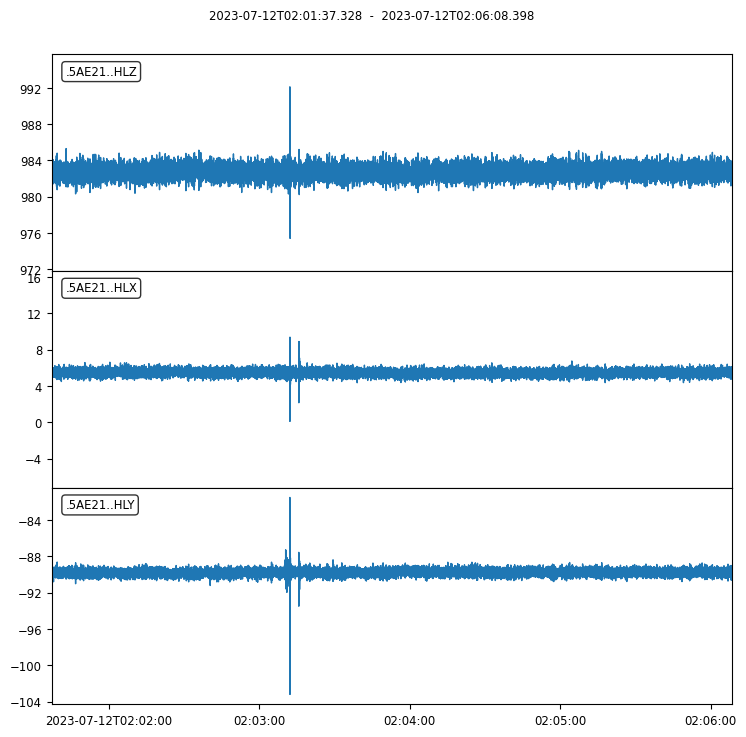

3 Trace(s) in Stream:
.5AE21..HLX | 2023-07-12T02:01:37.328000Z - 2023-07-12T02:06:08.398000Z | 100.0 Hz, 27108 samples
.5AE21..HLY | 2023-07-12T02:01:37.328000Z - 2023-07-12T02:06:08.398000Z | 100.0 Hz, 27108 samples
.5AE21..HLZ | 2023-07-12T02:01:37.328000Z - 2023-07-12T02:06:08.398000Z | 100.0 Hz, 27108 samples


In [12]:
index = 29
index = random.randint(0, len(stream_list))
index  = 20
index  = 457

rand_stream = stream_list[index]
rand_stream.plot(color = 'C0')
rand_stream.plot(color = 'C0', outfile = './event_noise/rand_stream_noise.pdf')

station_name = rand_stream[0].stats.location
instrument_name = rand_stream[0].stats.station
station_info = station_name + ' ' + instrument_name + ' '

print(rand_stream)


In [13]:
freq_min = 0   # Minimum frequency in Hz
freq_max = 20  # Maximum frequency in Hz

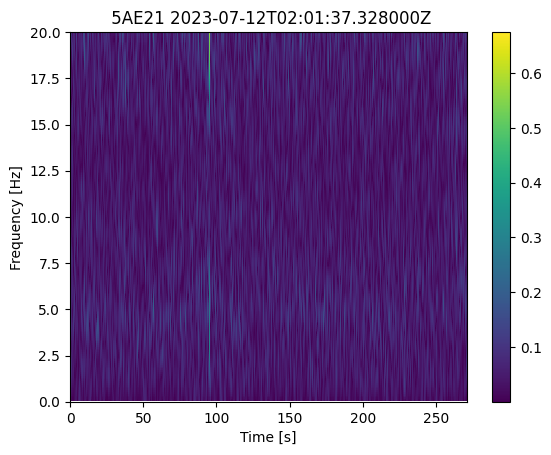

In [14]:
for tr in rand_stream:
    # tr.filter('bandpass', freqmin = 1.0, freqmax = 3.0)
    pass

rand_stream[2].detrend(type = "linear")
rand_stream[2].filter(type = "highpass", freq = 0.5)

rand_stream_spectrogram_ax = plt.axes()
rand_stream[2].spectrogram(log = False, axes = rand_stream_spectrogram_ax, show = False)
rand_stream_spectrogram_ax.set_title(station_info + str(rand_stream[2].stats.starttime))
# rand_stream_spectrogram_ax.set_xlim(xmin = 0, xmax = 200)
rand_stream_spectrogram_ax.set_ylim(ymin = freq_min, ymax = freq_max)

mappable = rand_stream_spectrogram_ax.images[0]
plt.colorbar(mappable = mappable, ax = rand_stream_spectrogram_ax)
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.savefig('./event_noise/rand_stream_noise_Spectrogram.pdf', dpi = 300)
plt.show()

In [15]:
for i in range(len(stream_list)):

    QSIS_train_data_list_append = process_obspy_stream(stream_list[i])

    for i in range(len(QSIS_train_data_list_append)):
        QSIS_train_data_list.append(QSIS_train_data_list_append[i])

In [16]:
QSIS_train_data_X = np.stack(QSIS_train_data_list)
QSIS_train_data_X = np.expand_dims(QSIS_train_data_X, axis = -1)

In [17]:
initial_array = np.array([[0., 0., 1.]])
QSIS_train_data_Y = np.tile(initial_array, (len(stream_list) * data_per_noise, 1))

print(QSIS_train_data_X.shape)
print(QSIS_train_data_Y.shape)


(725, 80, 3, 1)
(725, 3)


In [18]:
torch.save({'Xnoise': QSIS_train_data_X, 'Ynoise': QSIS_train_data_Y}, './data_QSIS_pth/noise.pth')

In [19]:
datadir = './data_QSIS_pth'

train_data_path = os.path.join(datadir, 'noise.pth')
train_data = torch.load(train_data_path)
Xnoise = train_data['Xnoise']
Ynoise = train_data['Ynoise']

print(Xnoise.shape)
print(Ynoise.shape)

(725, 80, 3, 1)
(725, 3)


In [20]:
print(len(stream_list) * data_per_noise)

725


In [21]:
def plot_all_noise():
    plot_number = len(stream_list)
    # plot_number = 3

    alpha = 0.05
    freq = 0.5

    for i in range(plot_number):
        check_stream = stream_list[i]

        check_stream.detrend(type = "linear")
        check_stream.taper(alpha)
        check_stream.filter(type = "highpass", freq = freq)

        check_stream.plot(color = 'C0')
        print(check_stream)